In [ ]:
!pip3 install torch torchvision -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


cifar10_train  = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

cifar10_test = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)



100%|██████████| 170M/170M [00:03<00:00, 46.3MB/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
cifar10_train

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

Label: 1


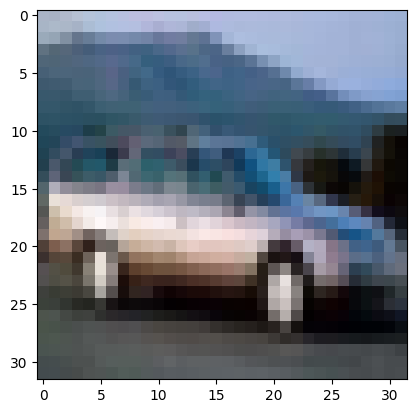

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

idx = 4

sample = cifar10_train[idx]
plt.imshow(np.transpose(sample[0].numpy(), (1, 2, 0)), cmap="gray")
print("Label: %d" % sample[1])



In [ ]:
def flatten_image(x, label=False):
    print(x)
    x, labels = zip(*x)

    if label:
        labels = torch.stack(labels)
        return torch.flatten(x[0],1), labels

    else:

        return torch.flatten(x[0],1)

In [ ]:
out = flatten_image([cifar10_train[0],cifar10_train[1]])
out

[(tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
         [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
         [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
         ...,
         [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
         [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
         [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],

        [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
         [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
         [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
         ...,
         [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
         [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
         [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],

        [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
         [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
         [0.0824, 0.0000, 0.0314,  ..., 0.1961, 0.1961, 

tensor([[0.2314, 0.1686, 0.1961,  ..., 0.8471, 0.5922, 0.4824],
        [0.2431, 0.1804, 0.1882,  ..., 0.7216, 0.4627, 0.3608],
        [0.2471, 0.1765, 0.1686,  ..., 0.5490, 0.3294, 0.2824]])

In [ ]:
! pip install keras-core



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 13.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras_core as keras

class BernoulliMLP(keras.Model):

    def __init__(self, input_shape, name='BernoulliMLP', hidden_dim=10, latent_dim=10, **kwargs):

        super().__init__(name=name, **kwargs)

        self._h = keras.layers.Dense(hidden_dim,

                                        activation='tanh')

        self._y = keras.layers.Dense(latent_dim,

                                        activation='sigmoid')

    def call(self, x):

        return self._y(self._h(x)), None, None

class GaussianMLP(keras.Model):

    def __init__(self, input_shape, name='GaussianMLP', hidden_dim=10, latent_dim=10, iaf=False, **kwargs):

        super().__init__(name=name, **kwargs)

        self._h = keras.layers.Dense(hidden_dim,

                                        activation='tanh')

        self._mean = keras.layers.Dense(latent_dim)

        self._logvar = keras.layers.Dense(latent_dim)

        self._iaf_output = None

        if iaf:

            self._iaf_output = keras.layers.Dense(latent_dim)

    def call(self, x):

        if self._iaf_output:

            return self._mean(self._h(x)), self._logvar(self._h(x)), self._iaf_output(self._h(x))

        else:

            return self._mean(self._h(x)), self._logvar(self._h(x)),  None

Using PyTorch backend.


In [ ]:
class VAE(keras.Model):

    def __init__(self, input_shape, name='variational_autoencoder',

                 latent_dim=10, hidden_dim=10, encoder='GaussianMLP',

                 decoder='BernoulliMLP', iaf_model=None,

                 number_iaf_networks=0,

                 iaf_params={},

                 num_samples=100, **kwargs):

        super().__init__(name=name, **kwargs)

        self._latent_dim = latent_dim

        self._num_samples = num_samples

        self._iaf = []

        if encoder == 'GaussianMLP':

            self._encoder = GaussianMLP(input_shape=input_shape,

                                        latent_dim=latent_dim,

                                        iaf=(iaf_model is not None),

                                        hidden_dim=hidden_dim)

        else:

            raise ValueError("Unknown encoder type: {}".format(encoder))

        if decoder == 'BernoulliMLP':

            self._decoder = BernoulliMLP(input_shape=(1,latent_dim),

                                         latent_dim=input_shape[1],

                                         hidden_dim=hidden_dim)

        elif decoder == 'GaussianMLP':

            self._encoder = GaussianMLP(input_shape=(1,latent_dim),

                                        latent_dim=input_shape[1],

                                        iaf=(iaf_model is not None),

                                        hidden_dim=hidden_dim)

        else:

            raise ValueError("Unknown decoder type: {}".format(decoder))

        if iaf_model:

            self._iaf = []

            for t in range(number_iaf_networks):

                self._iaf.append(

                    iaf_model(input_shape==(1,latent_dim*2),

                              **iaf_params))

    def encode(self, x):

          return self._encoder.call(x)


    def decode(self, z, apply_sigmoid=False):

        logits, _, _ = self._decoder.call(z)

        if apply_sigmoid:

            probs = torch.sigmoid(logits)

            return probs

        return logits


    def sample(self, eps=None):

        if eps is None:

            eps = torch.randn((self._num_samples,

                                          self.latent_dim))

        return self._decoder.call(eps, apply_sigmoid=False)


    def reparameterize(self, mean, logvar):

        eps = torch.randn(mean.shape)

        return eps * torch.exp(logvar * .5) + mean

    @property
    def iaf(self):

        return self._iaf

def log_normal_pdf(sample, mean, logvar, raxis=1):

  log2pi = torch.log(torch.tensor([2. * np.pi]))

  return -.5 * ((sample - mean) ** 2. * torch.exp(-logvar) + logvar + log2pi).detach().numpy()


def compute_loss(model, x):

  mean, logvar, h = model.encode(x)

  z = model.reparameterize(mean, logvar)

  logqz_x = log_normal_pdf(z, mean, logvar)

  for iaf_model in model.iaf:

      mean, logvar, _ = iaf_model.call(torch.concat([z, h], 1))

      s = torch.sigmoid(logvar)

      z = torch.add(torch.multiply(z,s), torch.multiply(mean,(1-s)))

      logqz_x -= torch.sum(torch.log(s)).detach().numpy()


  x_logit = model.decode(z)

  cross_ent = torch.nn.BCEWithLogitsLoss().forward(x_logit, x)

  logpx_z = -torch.sum(cross_ent)

  logpz = log_normal_pdf(z, torch.tensor([0.]), torch.tensor([0.]))

  return -torch.sum(logpx_z + logpz - logqz_x.detach())

def compute_apply_gradients(model, x, optimizer):
  x=x.detach()
  x=x.view(-1,32*32*3)
  loss = compute_loss(model, x)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()



In [ ]:
model = VAE(input_shape=(1,3072), hidden_dim=500, latent_dim=500)
model = VAE(input_shape=(1,3072), hidden_dim=500, latent_dim=500,

    iaf_model=GaussianMLP, number_iaf_networks=3,

    iaf_params={'latent_dim': 500, 'hidden_dim': 500, 'iaf': False})

In [ ]:
pip install torchviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

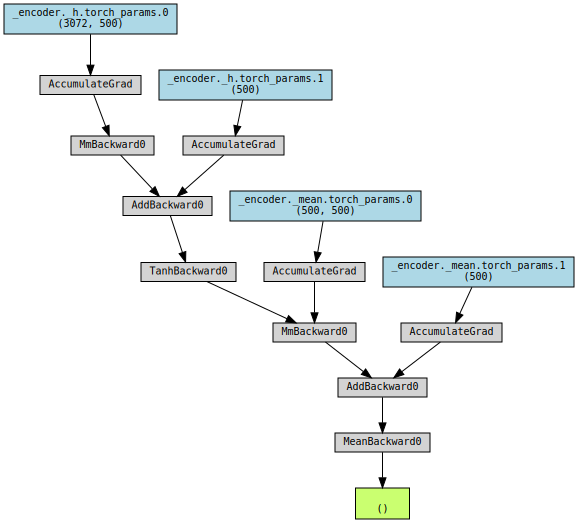

In [ ]:
from torchviz import make_dot
y = model.encode(torch.randn(1,3072))
make_dot(y[0].mean(), params=dict(model.named_parameters()))

In [ ]:
import time as time

epochs = 100
batch_size = 32

from torch.utils.data.dataloader import DataLoader
optimizer = keras.optimizers.Adam(1e-4)

cifar10_train_loaded = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True)

cifar10_test_loaded = DataLoader(cifar10_test, batch_size=batch_size, shuffle=True)

for epoch in range(1, epochs + 1):

    start_time = time.time()

    for train_x, label in cifar10_train_loaded:

        compute_apply_gradients(model, train_x, optimizer)

    end_time = time.time()

    if epoch % 1 == 0:

        loss = keras.metrics.Mean()

        for test_x, label in cifar10_test_loaded:

            loss(compute_loss(model, test_x))

    elbo = -loss.result()

    print('Epoch: {}, Test set ELBO: {}, '

          'time elapse for current epoch {}'.format(epoch, elbo, end_time - start_time))

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.